In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [159]:
t, k, T0, Ta = sympy.symbols('t, k, T_0, T_a')
T = sympy.Function("T")

In [160]:
ode = T(t).diff(t) + k*(T(t) - Ta)

In [161]:
sympy.Eq(ode,0)

Eq(k*(-T_a + T(t)) + Derivative(T(t), t), 0)

In [162]:
ode_sol = sympy.dsolve(ode)

In [163]:
ode_sol

Eq(T(t), C1*exp(-k*t) + T_a)

In [164]:
ode_sol.lhs

T(t)

In [165]:
ode_sol.rhs

C1*exp(-k*t) + T_a

In [166]:
ics = {T(0): T0}

In [167]:
ics

{T(0): T_0}

In [168]:
C_eq = ode_sol.subs(t, 0).subs(ics)

In [169]:
C_eq

Eq(T_0, C1 + T_a)

In [170]:
C_sol = sympy.solve(C_eq)

In [171]:
C_sol


[{C1: T_0 - T_a}]

In [172]:
ode_sol.subs(C_sol[0])

Eq(T(t), T_a + (T_0 - T_a)*exp(-k*t))

In [173]:
ode_sol.free_symbols

{C1, T_a, k, t}

In [7]:
def apply_ics(sol, ics, x, known_params):
    """
    Apply the initial conditions (ics), given as a dictionary on the form 
    ics = {y(0): y0, y(x).diff(x).subs(x, 0): yp0, ...}, to the solution of the ODE
    with independent variable x.
    The undetermined integration constants C1, C2, ... are extracted from the free
    symbols of the solution, excluding symbols in the known_params list.
    """
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics) for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    return sol.subs(sol_params)

In [175]:
apply_ics(ode_sol, ics,t,[k, t,Ta])

Eq(T(t), T_a + (T_0 - T_a)*exp(-k*t))

In [176]:
t, omega0, gamma = sympy.symbols("t, omega_0, gamma", positive=True)

In [177]:
x = sympy.Function('x')

In [178]:
ode = x(t).diff(t, 2) + 2 * gamma * omega0 * x(t).diff(t) + omega0**2 * x(t)

In [179]:
sympy.Eq(ode, 0)

Eq(2*gamma*omega_0*Derivative(x(t), t) + omega_0**2*x(t) + Derivative(x(t), (t, 2)), 0)

In [180]:
ode_sol = sympy.dsolve(ode)

In [181]:
ode_sol

Eq(x(t), C1*exp(omega_0*t*(-gamma - sqrt(gamma - 1)*sqrt(gamma + 1))) + C2*exp(omega_0*t*(-gamma + sqrt(gamma - 1)*sqrt(gamma + 1))))

In [182]:
ics = {x(0): 1, x(t).diff(t).subs(t, 0): 0}

In [183]:
ics

{x(0): 1, Subs(Derivative(x(t), t), t, 0): 0}

In [184]:
x_t_sol = apply_ics(ode_sol, ics, t, [omega0, gamma])

In [185]:
x_t_sol

Eq(x(t), (-gamma/(2*sqrt(gamma**2 - 1)) + 1/2)*exp(omega_0*t*(-gamma - sqrt(gamma - 1)*sqrt(gamma + 1))) + (gamma/(2*sqrt(gamma**2 - 1)) + 1/2)*exp(omega_0*t*(-gamma + sqrt(gamma - 1)*sqrt(gamma + 1))))

However, substituting $\gamma = 1$, which corresponds to critical damping, directly into this expression results
in a division by zero error, and for this particular choice of $\gamma$, we need to be careful and compute the limit where $\gamma \rightarrow 1$.

In [186]:
x_t_critical = sympy.limit(x_t_sol.rhs, gamma, 1)
x_t_critical

(omega_0*t + 1)*exp(-omega_0*t)

In [187]:
x_t_critical

(omega_0*t + 1)*exp(-omega_0*t)

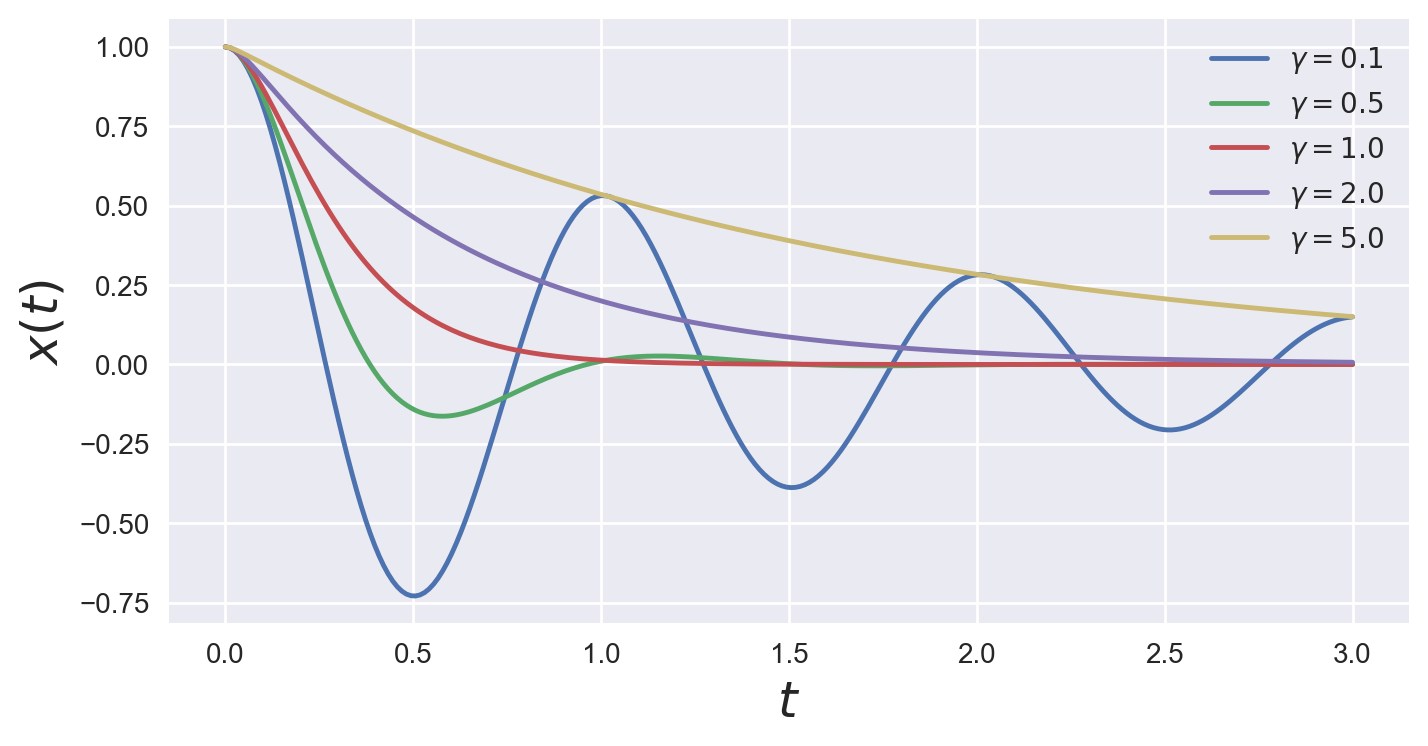

In [188]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
tt = np.linspace(0, 3, 250)
w0 = 2 * sympy.pi
for g in [0.1, 0.5, 1, 2.0, 5.0]:
    x_t_critical = sympy.limit(x_t_sol.rhs, gamma, g)
    x_t = sympy.lambdify(t, x_t_critical.subs({omega0: w0}), 'numpy')
    ax.plot(tt, x_t(tt).real, label=r"$\gamma = %.1f$" % g)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$x(t)$", fontsize=18)
ax.legend()

In [189]:
x = sympy.symbols('x')
y = sympy.Function('y')

In [190]:
f = y(x)**2 +x

In [191]:
sympy.Eq(y(x).diff(x), f)

Eq(Derivative(y(x), x), x + y(x)**2)

In [192]:
sympy.dsolve(y(x).diff(x) - f)

Eq(y(x), x**2*(2*C1**3 + 1)/2 + x**5*(10*C1**3*(6*C1**3 + 1) + 20*C1**3 + 3)/60 + C1 + C1*x**3*(3*C1**3 + 1)/3 + C1**2*x + C1**2*x**4*(12*C1**3 + 5)/12 + O(x**6))

In [193]:
sympy.Eq(y(x).diff(x, x), f)

Eq(Derivative(y(x), (x, 2)), x + y(x)**2)

In [195]:
def plot_direction_field(x, y_x, f_xy, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    x_vec = np.linspace(x_lim[0], x_lim[1], 30)
    y_vec = np.linspace(y_lim[0], y_lim[1], 30)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))
        
    dx = x_vec[1] - x_vec[0]
    dy = x_vec[1] - y_vec[0]
    
    for m, xx in enumerate(x_vec):
        for m, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8 * dx**2 / np.sqrt(dx**2 + Dy**2)
            Dy = 0.8 * Dy*dy / np.sqrt(dx**2 + Dy**2)
            ax.plot([xx - Dx/2, xx + Dx/2],
                   [yy - Dy/2, yy+ Dy/2], 'b', lw=0.5)
    
    ax.axis('tight')
    ax.set_title(r"$%s$" % 
                 (sympy.latex(sympy.Eq(y(x).diff(x), f_xy))),  fontsize=18)
    return ax

In [196]:
x = sympy.symbols('x')
y = sympy.Function('y')

<AxesSubplot:title={'center':'$\\frac{d}{d x} y{\\left(x \\right)} = \\frac{y^{2}{\\left(x \\right)}}{x}$'}>

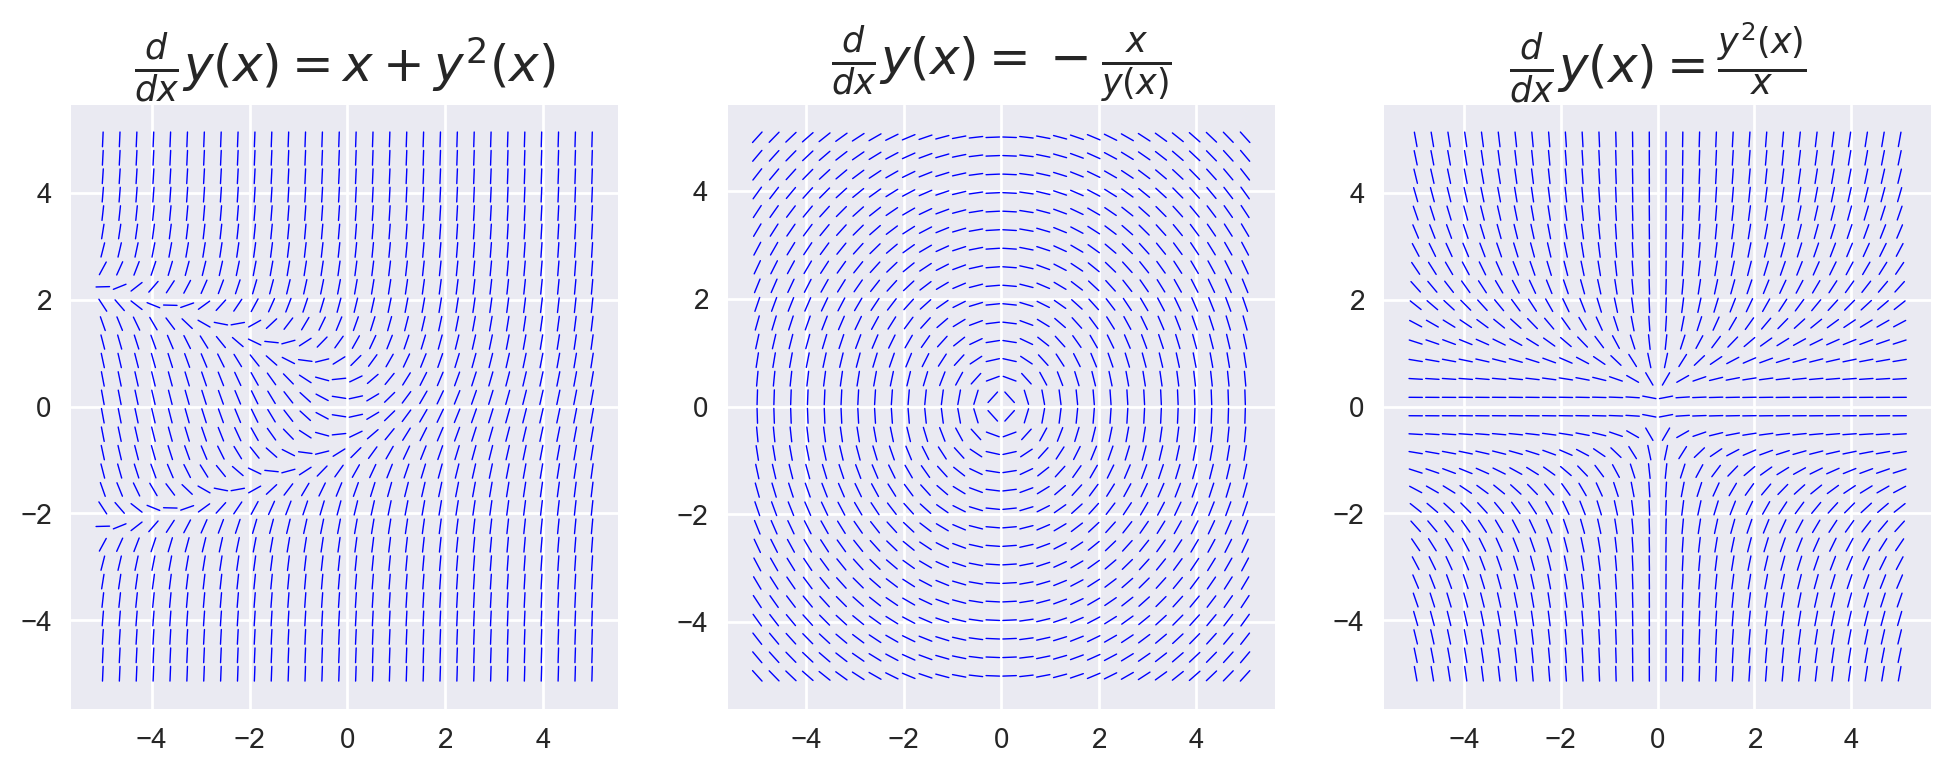

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_direction_field(x, y(x), y(x)**2 + x,ax=axes[0])
plot_direction_field(x, y(x), -x / y(x), ax = axes[1])
plot_direction_field(x, y(x), y(x)**2 / x, ax=axes[2])

In [198]:
x = sympy.symbols('x')
y = sympy.Function('y')
f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

Eq(Derivative(y(x), x), x + y(x)**2)

In [199]:
ics = {y(0): 0}

In [200]:
ode_sol = sympy.dsolve(y(x).diff(x) - f, ics=ics)
ode_sol

Eq(y(x), x**2/2 + x**5/20 + O(x**6))

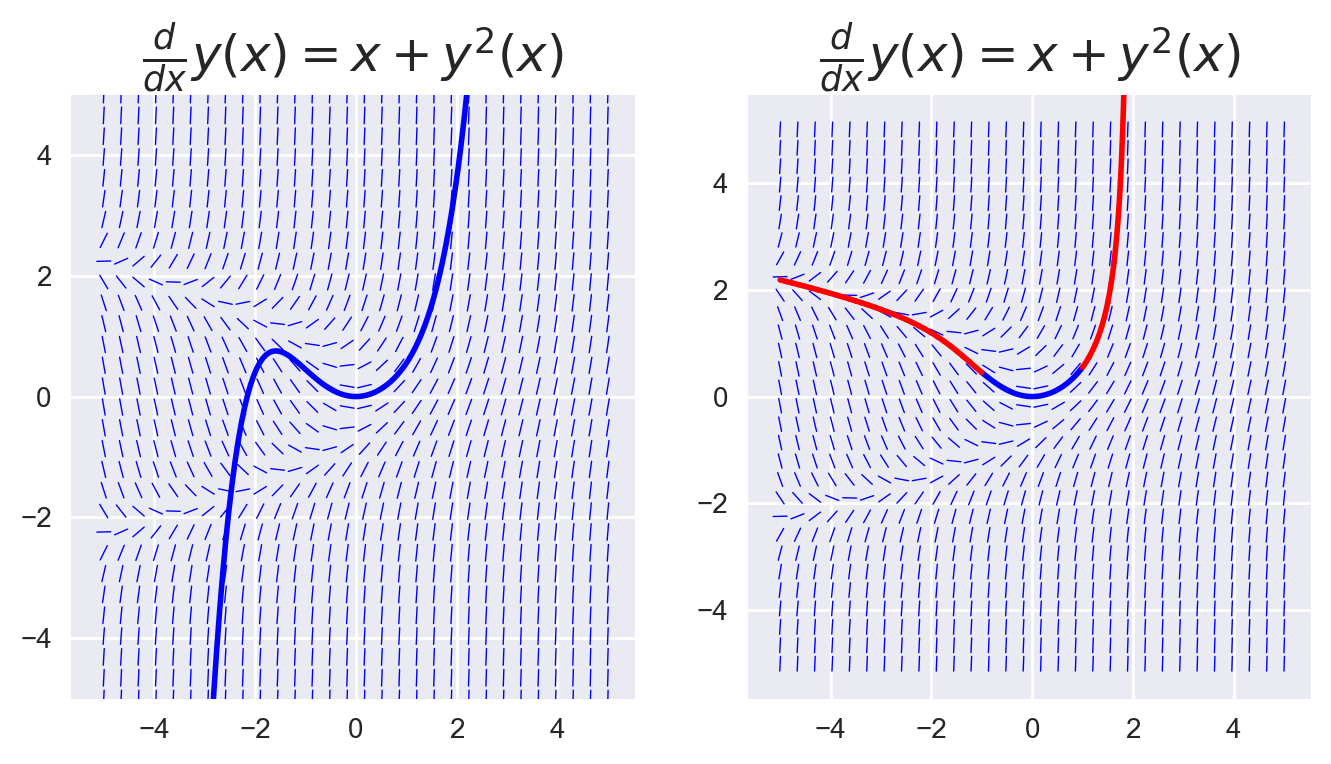

In [201]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
#left panel
plot_direction_field(x, y(x), f, ax=axes[0])
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

#right panel
plot_direction_field(x, y(x), f, ax=axes[1])
x_vec = np.linspace(-1,1,100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
#iteratively resolve the ODE with updated initial conditions
ode_sol_m = ode_sol_p = ode_sol
dx = 0.125
#positive x
for x0 in np.arange(1, 2., dx):
    x_vec = np.linspace(x0, x0 + dx, 100)
    ics = {y(x0): ode_sol_p.rhs.removeO().subs(x, x0)}
    ode_sol_p = sympy.dsolve(y(x).diff(x) -f, ics= ics, n = 6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_p.rhs.removeO())(x_vec), 'r', lw=2)

#negative x
for x0 in np.arange(-1, -5, -dx):
    x_vec = np.linspace(x0, x0 - dx, 100)
    ics = {y(x0): ode_sol_m.rhs.removeO().subs(x, x0)}
    ode_sol_m = sympy.dsolve(y(x).diff(x) -f , ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_m.rhs.removeO())(x_vec), 'r', lw=2)

In [202]:
x = sympy.symbols('x')
y = sympy.Function('y')

In [203]:
f = y(x)**2 + x

In [204]:
f_np = sympy.lambdify((y(x), x), f)

In [205]:
y0 = 1

In [206]:
xp = np.linspace(0, 1.9, 100)
yp = integrate.odeint(f_np, y0, xp)

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [207]:
xm = np.linspace(0, -5, 100)
ym = integrate.odeint(f_np, y0, xm)

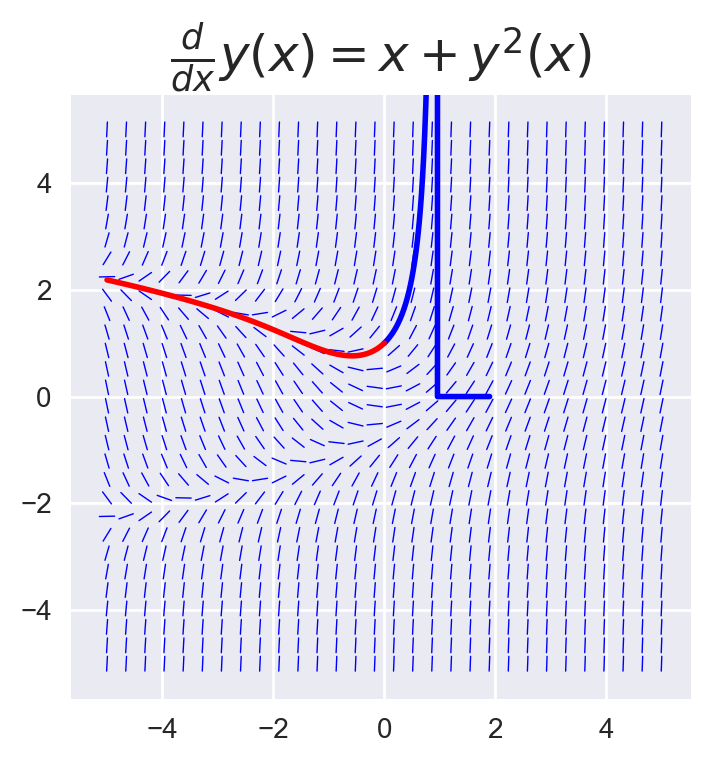

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_direction_field(x, y(x), f, ax=ax)
ax.plot(xp, yp, 'b', lw=2)
ax.plot(xm, ym, 'r', lw=2)

In [111]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7

In [115]:
def f(xy, t):
    x, y = xy
    return [a * x -b * x * y, c * x * y - d * y]

In [123]:
xy0 = [600, 400]
t = np.linspace(0, 50, 250)
xy_t = integrate.odeint(f, xy0, t)
xy_t.shape

(250, 2)

Text(0, 0.5, 'Number of predators')

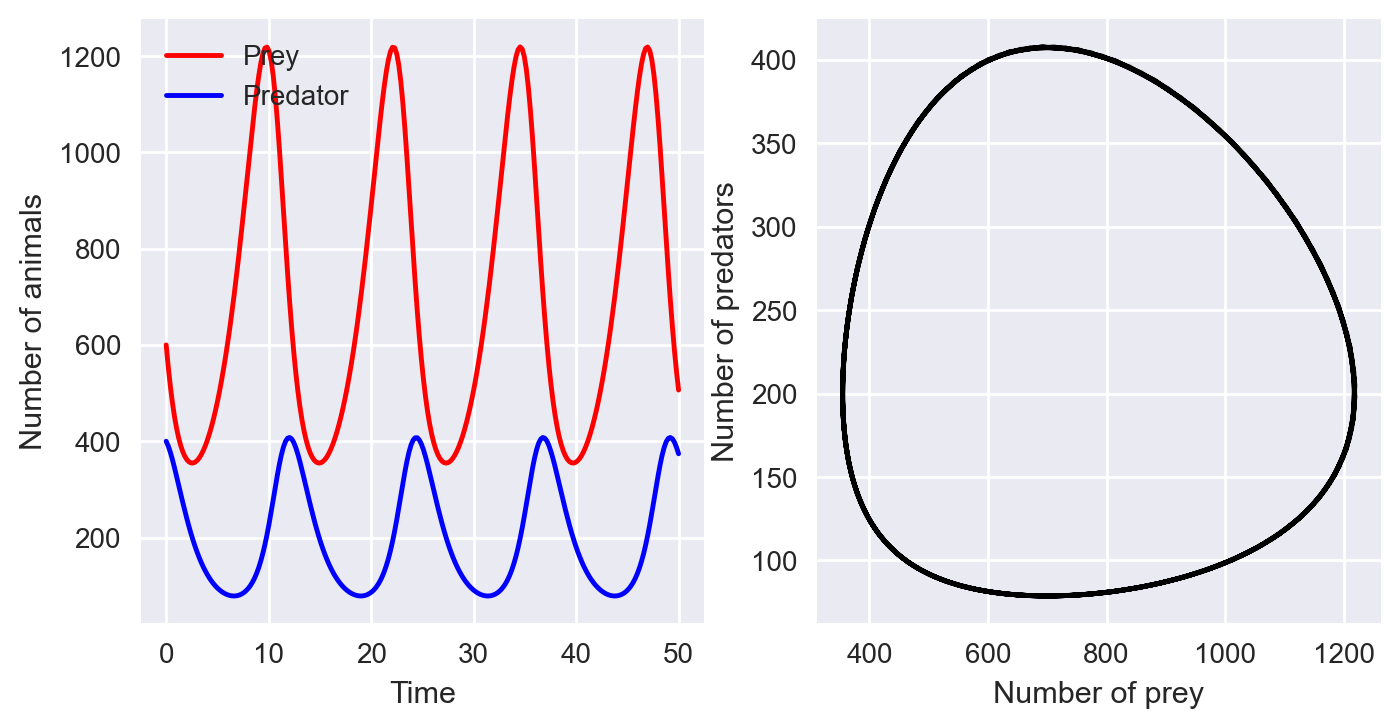

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(t, xy_t[:, 0], 'r', label='Prey')
axes[0].plot(t, xy_t[:, 1], 'b', label='Predator')
axes[0].set_xlabel("Time")
axes[0].set_ylabel('Number of animals')
axes[0].set_xlabel('Time')
axes[0].legend()
axes[1].plot(xy_t[:, 0], xy_t[:, 1], 'k')
axes[1].set_xlabel('Number of prey')
axes[1].set_ylabel('Number of predators')

In [2]:
from sympy.codegen.cfunctions import Sqrt
x, y = sympy.symbols('x, y')
z1 = sympy.symbols('z_1')
z2 = sympy.symbols('z_2')
n = sympy.Function("n")
s = 1 + z2**2
n = sympy.exp(-((x-1)**2 + (z1-0)**2)/0.2)+1
n_ = sympy.lambdify([x, z1], n, 'numpy')
L =n * Sqrt(s)
RHS = 1/n * n.diff(z1) * s +z2**2/s -1/n * (n.diff(x) + n.diff(z1) * z2) * z2
RHS = sympy.Lambda((x, z1, z2), RHS)
def f(z1z2, x):
    z1, z2 = z1z2
    return [z2, RHS(x, z1, z2)]

In [1]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
for z1 in np.arange(-1, 1, 0.1):
    z1z2 = [z1, 0]
    x1 = np.linspace(-3, 3, 500)
    z1z2_x = integrate.odeint(f, z1z2, x1, rtol=1.49012e-10, atol=1.49012e-10)
    ax.plot(x1, z1z2_x[:, 0], 'b', label='light ray', lw=0.1)


delta=0.01
x2 = y2 = np.arange(-3,3, delta)
X, Y = np.meshgrid(x2, y2)
Z =  n_(X, Y)

im = ax.imshow(Z, interpolation='bilinear', cmap=cm.RdBu_r,
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=abs(Z).max(), vmin=-abs(Z).max())
plt.colorbar()

NameError: name 'plt' is not defined